In [1]:
import os, sys
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# PYTORCH APPROACH

#### Custom dataset

In [2]:
from torch.utils.data import Dataset

In [3]:
class ROOT_dataset(Dataset):
    '''
        This class is used to:
            - read a root file;
            - get all relevant histograms in the root file and convert them to 1d numpy arrays;
            - read the csv file with labels corresponding to the histograms;
            - match the 1d numpy arrays with the labels;
            - return the matched data as a dataset.
        Input: 
            - annotation_file: the csv file with the labels;
            - root_file: the root file with histograms;
        Output:
            - pytorch dataset ready to be used for the training of a neural network.
    '''
    def __init__(self, annotation_file, path_to_root_file, histtype='hist_0'):
        self.root_annotated = pd.read_csv(annotation_file)
        self.root_file, self.all_histtype_keys = self.read_root(path_to_root_file, histtype=histtype)
        self.histtype = histtype
        self.listCHN = self.root_annotated['#Ch.#'].tolist()
        # self.primary_target_cols = ['t', 'E(t)', 'A_0', 'E(A_0)', 't_p', 'E(t_p)', 'k3', 'E(k3)', 'k4', 'E(k4)', 'k5', 'E(k5)', 'k6', 'E(k6)', 'Chi2/DOF']
        self.primary_target_cols = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def __len__(self):
        return len(self.root_annotated)

    def __getitem__(self, channelNumber):
        histname = '_'.join([self.histtype, 'channel', f'{channelNumber};1'])
        hist = self.get_histogram(root_data=self.root_file, histname=histname)
        if channelNumber in self.listCHN:
            target = self.root_annotated.loc[self.root_annotated['#Ch.#']==channelNumber][self.primary_target_cols]
            return hist, target.values
        else:
            return hist, None
    
    def read_root(self, filename, histtype='hist_0', filetype='rawdata'):
        root_file = uproot.open(filename)
        print(len(root_file.keys()))
        all_histtype_keys = []
        for key in root_file.keys():
            if ('RawData' not in key) and ('FitResults' not in key):
                if histtype in key:
                    all_histtype_keys.append(key)
        return root_file, all_histtype_keys

    def get_histogram(self, root_data, histname):
        TH1D_hist = root_data[histname].to_numpy()
        return TH1D_hist

In [4]:
dataset = ROOT_dataset(annotation_file='data/run_30413/run_30413_labelled.csv', path_to_root_file='raw_waveforms_run_30413.root', histtype='hist_0')
dataset.__getitem__(channelNumber=29)


33927


((array([ 6.000e+00,  1.100e+01,  1.400e+01,  1.900e+01,  2.200e+01,
          2.300e+01,  1.800e+01,  1.400e+01,  9.000e+00,  2.000e+00,
          7.100e+01,  1.196e+03,  3.741e+03,  6.197e+03,  7.224e+03,
          6.631e+03,  5.053e+03,  3.269e+03,  1.786e+03,  7.820e+02,
          2.280e+02, -1.400e+01, -8.400e+01, -8.100e+01, -4.700e+01,
         -1.300e+01,  1.600e+01,  4.300e+01,  5.700e+01,  5.900e+01,
          6.200e+01,  6.400e+01,  6.500e+01,  6.500e+01,  7.000e+01,
          7.300e+01,  7.400e+01,  7.300e+01,  6.900e+01,  6.300e+01,
          5.600e+01,  4.900e+01,  4.000e+01,  3.400e+01,  3.300e+01,
          2.900e+01,  2.800e+01,  3.200e+01,  4.000e+01,  4.600e+01,
          4.700e+01,  4.400e+01,  3.800e+01,  3.600e+01,  4.100e+01,
          4.500e+01,  4.500e+01,  4.300e+01,  4.500e+01,  5.100e+01,
          5.900e+01,  6.600e+01,  6.400e+01,  5.600e+01,  4.800e+01,
          4.900e+01,  5.100e+01,  5.300e+01,  4.900e+01,  3.900e+01,
          2.800e+01,  3.200e+01,  

In [5]:
hist, target = dataset.__getitem__(channelNumber=20)

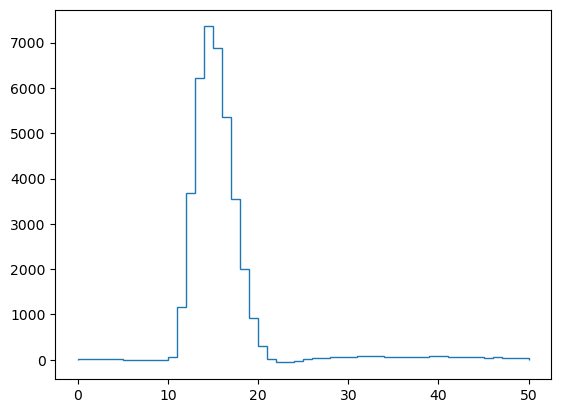

In [15]:
plt.figure()
# plt.plot(hist[1][:100], hist[0][:100])
plt.stairs(hist[0][:50])
plt.show()

In [7]:
pd.DataFrame(target, columns=dataset.primary_target_cols)

,t,A_0,t_p,k3,k4,k5,k6
0,5.036479,79272.01603,2.14184,0.477705,0.567924,0.120598,0.107032


In [9]:
from torch.utils.data import DataLoader
dataset = ROOT_dataset(
    annotation_file='data/run_30413/run_30413_labelled.csv', 
    path_to_root_file='raw_waveforms_run_30413.root',
    histtype='hist_0'
)

batch_size = 16
train_loader = DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

33927


In [8]:
import torch
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Ti Laptop GPU'

In [202]:
import torch
from torch import nn
import torch.nn.functional as F

class EncoderWF(nn.Module):
    def __init__(self, input_channels=2, hidden_dims=(32, 64, 128), kernel_size=3, stride=1):
        pass

In [203]:
dataset[0][0][0].shape

(331,)

# Generating the waveforms using the fit parameters (simulation)

In [2]:
from response import *

In [365]:
class Sim_waveform:
    def __init__(self, path_to_sim=None, output_path=None):
        self.path_to_sim = path_to_sim
        self.output_path = output_path
        self.sim_data = pd.DataFrame()
        if self.path_to_sim is not None:
            self.sim_data = self.read_csv_sim()
        self.response_params = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']

    def read_csv_sim(self):
        tmpdata = pd.read_csv(self.path_to_sim)
        cols = list(tmpdata.columns)
        cols_to_be_removed = [c for c in cols if 'Unnamed' in c]
        tmpdata.drop(labels=cols_to_be_removed, axis=1, inplace=True)
        tmpdata['#Ch.#'] = tmpdata['#Ch.#'].astype('int32')
        return tmpdata
    
    def __generate_1wf(self, params=None):
        if params is None:
            return None
        x = np.linspace(params[0], params[0]+70, 70)
        R = response(x=x, par=params)
        return R
    
    def run(self):
        # N_samples = self.sim_data.shape[0]
        N_samples = 10000
        key_name = self.path_to_sim.split('/')[-1].split('.')[0].split('_')[3]
        for isample in range(N_samples):
            params = list(self.sim_data[self.response_params].iloc[isample])
            R = self.__generate_1wf(params=params)
            dict_params = dict(zip(self.response_params, params))
            dict_params['class'] = self.sim_data['class'].iloc[isample]
            dict_params['wf'] = R
            dict_params['integral_R'] = self.sim_data['integral_R'].iloc[isample]
            dict_params['max_deviation'] = self.sim_data['max_deviation'].iloc[isample]
            np.savez(f'{self.output_path}/wf_{key_name}_{isample}.npz', **dict_params)


In [366]:
sim_wf_obj = Sim_waveform(path_to_sim='data/labelledData/labelledData/generated_new_samples_c3_labelled_tails.csv',
                          output_path='data/labelledData/labelledData/WF_sim/')
sim_wf_obj.run()

# BDT approach

**The dataset we want to use are the numpy files npz which might require a large memory. For that reason, we want to load them chunk by chunk and train the model using chunks.**

In [5]:
import xgboost as xgb
from util_bdt import dataframe2DMatrix, one_hot_encode_sklearn

In [6]:
class Load_chunk_dset:
    '''
        This class will load a chunk of the data.
    '''
    def __init__(self, path_to_dset: str, chunk_size=5, target_columns=['']):
        self.path_to_dset = path_to_dset
        self.list_dset = ['/'.join([self.path_to_dset, f]) for f in os.listdir(self.path_to_dset)[:5000]]
        self.target_columns = target_columns
        self.input_columns = [f'p{i}' for i in range(70)]
        self.chunk_size = chunk_size
        self.iter = 0

    def npz2df(self, filepath='', forTest_regressor=False):
        data = np.load(filepath)
        wf = np.array(data['wf']).reshape(-1, 1)
        wf_dict = {f'p{i}': wf[i] for i in range(len(wf))}
        keys = [c for c in list(data.keys()) if c!='wf']
        for k in keys:
            wf_dict[k] = np.array(data[k].flatten())
        wf_df = pd.DataFrame(wf_dict)

        if forTest_regressor:
            # split features (input) and target values
            y = wf_df[self.target_columns]
            X = wf_df[self.input_columns]
            # return xgb.DMatrix(X, label=None), y
            return dataframe2DMatrix(X=X), y
        else:
            return wf_df

    def reset(self):
        self.iter = 0
        return self
    
    def load(self, tasktype='regression'):
        try:
            chunk = pd.DataFrame()
            if self.chunk_size*(self.iter+1) > len(self.list_dset)-1:
                return None
            for i, ichunk in enumerate(range(self.iter*self.chunk_size, (self.iter+1)*self.chunk_size)):
                df = self.npz2df(filepath=self.list_dset[ichunk])
                if i==0:
                    chunk = df.copy()
                else:
                    chunk = pd.concat([chunk, df], axis=0)
            if len(chunk)==0:
                return None
            self.iter += 1
            if tasktype=='regression':
                # split features (input) and target values
                # y = chunk[self.target_columns].values
                # X = chunk[self.input_columns].values
                # return xgb.DMatrix(X, label=y)
                #
                # use dataframes
                y = chunk[self.target_columns]
                X = chunk[self.input_columns]
                return dataframe2DMatrix(X=X, y=y)
            elif tasktype=='classification':
                tmp_chunk = one_hot_encode_sklearn(data=chunk, column_name='class')
                X = tmp_chunk[self.input_columns]
                y = tmp_chunk[self.target_columns]
                return dataframe2DMatrix(X=X, y=y)
        except:
            return None
    
        
class PreClassifier_BDT:
    '''
        Given a waveform as input, this class will:
            - predict the fit parameters
            - classify them into four classes c1, c2, c3, c4
        using a boosted decision tree.
        Inputs:
            path_to_data: path to the dataset used for training the regression and classification models.
                        This dataset located at this path should be a numpy dataset (npz) which contains the wf datapoints,
                        the fit parameters ('t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6'), and the corresponding class ('class').
            output_path : path to where the output will be saved.
    '''
    def __init__(self, path_to_data=None, output_path=None, target_columns=['']):
        '''
            path_to_data : path to the list of npz data,
            output_path : path to where you want to save the output of the code.
        '''
        self.path_to_data = path_to_data
        self.output_path = output_path
        self.target_columns = target_columns


    def tune_hyperparam_bdt(self):
        params = {
            
        }


    # def regression(self):
    def Train_bdt(self, tasktype='regression'):
        objective = 'reg:squarederror'
        eval_metric = 'rmse'
        if tasktype=='classification':
            objective = 'binary:logistic'
            eval_metric = 'logloss'
        params = {
            'objective': objective,
            'eval_metric' : eval_metric,
            'tree_method': 'hist',
            'device': 'cuda',
            'max_depth': 15,
            'learning_rate': 0.4,
            'min_child_weight' : 15,
            'num_boost_round': 200,
            'subsample': 1.0,
            'colsample_bytree': 1.0
        }

        data_iter = Load_chunk_dset(path_to_dset=self.path_to_data, chunk_size=200, target_columns=self.target_columns)
        next_chunk = data_iter.load(tasktype=tasktype)
        eval_chunk = data_iter.load(tasktype=tasktype)
        # regressor_model = xgb.XGBRegressor(**params)
        # regressor_model.fit(X=next_chunk[0],y=next_chunk[1])
        bdt_model = xgb.train(params=params,
                                    dtrain = next_chunk,
                                    evals=[(next_chunk, 'train'), (eval_chunk, 'eval')],
                                    early_stopping_rounds=20,
                                    xgb_model=None,
                                    verbose_eval=True)
        next_chunk = data_iter.load(tasktype=tasktype)
        eval_chunk = data_iter.load(tasktype=tasktype)
        while (next_chunk is not None) and (eval_chunk is not None):
            bdt_model = xgb.train(params=params,
                                        dtrain = next_chunk,
                                        xgb_model = bdt_model,
                                        evals=[(next_chunk, 'train'), (eval_chunk, 'eval')],
                                        early_stopping_rounds=20,
                                        verbose_eval=True)
            next_chunk = data_iter.load(tasktype=tasktype)
            eval_chunk = data_iter.load(tasktype=tasktype)
        return bdt_model
    
    def testRegressor(self, regressor_predFitParams=None, regressor_predIntegral=None, regressor_predMaxdev=None, Ntest=100):
        if regressor_predFitParams is None:
            return None
        
        if regressor_predIntegral is None:
            return None
        
        if regressor_predMaxdev is None:
            return None
        
        list_dset = ['/'.join([self.path_to_data, f]) for f in os.listdir(self.path_to_data)[5000:5000+Ntest]]
        target_columns = self.target_columns + ['integral_R', 'max_deviation']
        data_iter = Load_chunk_dset(path_to_dset=self.path_to_data, chunk_size=0, target_columns=target_columns)
        
        # load the regression model trained to predict the value of the integral
        regressor_predIntegral_model = xgb.Booster()
        regressor_predIntegral_model.load_model(regressor_predIntegral)

        # load the regression model trained to predict the value of the maximum deviation between tails
        regressor_predMaxdev_model = xgb.Booster()
        regressor_predMaxdev_model.load_model(regressor_predMaxdev)

        comparison_df = pd.DataFrame()
        for j, f in enumerate(list_dset):
            dtest, ytest = data_iter.npz2df(filepath=f, forTest_regressor=True)
            # predict the fit parameters using the waveform as input
            predictions = regressor_predFitParams.predict(dtest)
            pred_df = pd.DataFrame({f'{self.target_columns[i]}': predictions.reshape(-1,1)[i] for i in range(len(self.target_columns))})
            
            # predict the integral of the tail using the fit parameters as input
            ytest_fitparams = ytest[['A_0', 't_p', 'k3', 'k4', 'k5', 'k6']]
            ytest_dmatrix = xgb.DMatrix(ytest_fitparams, label=None)
            #
            # prediction of integral using truth information
            pred_integral_ofTruth = regressor_predIntegral_model.predict(ytest_dmatrix)
            # prediction of integral using predicted fit parameters
            ypred_dmatrix = xgb.DMatrix(pred_df[['A_0', 't_p', 'k3', 'k4', 'k5', 'k6']], label=None)
            pred_integral_ofPred = regressor_predIntegral_model.predict(ypred_dmatrix)
            #
            # prediction of the max deviation using the true information
            pred_maxdev_ofTruth = regressor_predMaxdev_model.predict(ytest_dmatrix)
            # prediction of the max deviation using the predicted fit parameters
            pred_maxdev_ofPred = regressor_predMaxdev_model.predict(ypred_dmatrix)

            # print('\n')
            # print(pred_integral[0], ytest['integral_R'].iloc[0])

            cols = [f'{c}_pred' for c in pred_df.columns]
            pred_df.columns = cols
            cols = [f'{c}_truth' for c in ytest_fitparams.columns]
            ytest_fitparams.columns = cols

            # concatenate
            pred_df = pd.concat([ytest_fitparams, pred_df], axis=1)
            # integral
            pred_df['integral_R_truth_truth'] = [ytest['integral_R'].iloc[0]]
            pred_df['integral_R_truth_pred'] = pred_integral_ofTruth
            pred_df['integral_R_pred_pred'] = pred_integral_ofPred
            # max deviation
            pred_df['max_deviation_truth_truth'] = [ytest['max_deviation'].iloc[0]]
            pred_df['max_deviation_truth_pred'] = pred_maxdev_ofTruth
            pred_df['max_deviation_pred_pred'] = pred_maxdev_ofPred
            
            if j==0:
                comparison_df = pred_df.copy()
            else:
                comparison_df = pd.concat([comparison_df, pred_df.copy()], axis=0)

        return comparison_df
        
    def classification(self):
        pass
    

In [7]:
target_columns = ['t', 'A_0', 't_p', 'k3', 'k4', 'k5', 'k6']
# target_columns = ['class_c3']
# chunk_dset_obj = Load_chunk_dset(path_to_dset='data/labelledData/labelledData/WF_sim', chunk_size=5, target_columns=taget_columns)
# chunk_dset_obj.test()
preclassifier_obj = PreClassifier_BDT(path_to_data='data/labelledData/labelledData/WF_sim', output_path='OUTPUT/Preclassifier', target_columns=target_columns)
regressor_model = preclassifier_obj.Train_bdt(tasktype='regression')
test_df = preclassifier_obj.testRegressor(regressor_predFitParams=regressor_model, Ntest=5000, regressor_predIntegral='OUTPUT/Kept_RESULTS/OK_SIMULATION_moreSamplesThanApr12_2025/integral_R_model.json',
                                          regressor_predMaxdev='OUTPUT/Kept_RESULTS/OK_SIMULATION_moreSamplesThanApr12_2025/max_deviation_model.json')

[0]	train-rmse:16120.67428	eval-rmse:17063.96057
[1]	train-rmse:9979.92512	eval-rmse:10830.83112
[2]	train-rmse:6251.73233	eval-rmse:7090.24353
[3]	train-rmse:4017.26197	eval-rmse:4870.95027
[4]	train-rmse:2685.12300	eval-rmse:3609.32556
[5]	train-rmse:1930.35053	eval-rmse:3003.75943
[6]	train-rmse:1502.84600	eval-rmse:2649.71465
[7]	train-rmse:1242.10860	eval-rmse:2446.33304
[8]	train-rmse:1114.85021	eval-rmse:2396.47332
[9]	train-rmse:1003.39413	eval-rmse:2325.51303


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1922.02475	eval-rmse:2072.05386
[1]	train-rmse:1760.03978	eval-rmse:2035.27828
[2]	train-rmse:1608.85368	eval-rmse:1986.84395
[3]	train-rmse:1519.34125	eval-rmse:1938.88713
[4]	train-rmse:1418.80162	eval-rmse:1937.97456
[5]	train-rmse:1326.66095	eval-rmse:1931.97366
[6]	train-rmse:1262.91977	eval-rmse:1924.79462
[7]	train-rmse:1197.64470	eval-rmse:1914.07335
[8]	train-rmse:1156.08871	eval-rmse:1901.98114
[9]	train-rmse:1103.60595	eval-rmse:1914.04669


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1819.04974	eval-rmse:2377.79637
[1]	train-rmse:1656.69562	eval-rmse:2411.82256
[2]	train-rmse:1515.17287	eval-rmse:2447.68298
[3]	train-rmse:1389.84828	eval-rmse:2454.08397
[4]	train-rmse:1287.00048	eval-rmse:2446.40940
[5]	train-rmse:1232.95360	eval-rmse:2419.87066
[6]	train-rmse:1145.37978	eval-rmse:2432.77998
[7]	train-rmse:1108.79845	eval-rmse:2421.21859
[8]	train-rmse:1056.94437	eval-rmse:2404.43570
[9]	train-rmse:997.32325	eval-rmse:2397.38883


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1745.84324	eval-rmse:2289.63846
[1]	train-rmse:1573.64552	eval-rmse:2273.02652
[2]	train-rmse:1446.44045	eval-rmse:2261.63555
[3]	train-rmse:1336.95803	eval-rmse:2254.86403
[4]	train-rmse:1262.53828	eval-rmse:2271.16804
[5]	train-rmse:1202.67512	eval-rmse:2270.11521
[6]	train-rmse:1142.89276	eval-rmse:2256.41901
[7]	train-rmse:1062.96286	eval-rmse:2257.93490
[8]	train-rmse:1005.96842	eval-rmse:2251.29659
[9]	train-rmse:953.67216	eval-rmse:2269.40140


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1741.28992	eval-rmse:2065.62789
[1]	train-rmse:1598.21732	eval-rmse:2068.94307
[2]	train-rmse:1475.56289	eval-rmse:2050.63979
[3]	train-rmse:1406.35554	eval-rmse:2040.42952
[4]	train-rmse:1332.76629	eval-rmse:2011.83602
[5]	train-rmse:1265.50819	eval-rmse:2012.27801
[6]	train-rmse:1220.53017	eval-rmse:2016.63140
[7]	train-rmse:1154.75341	eval-rmse:1987.18518
[8]	train-rmse:1097.35682	eval-rmse:1978.02529
[9]	train-rmse:1050.34425	eval-rmse:1970.06008


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1603.38063	eval-rmse:1667.29054
[1]	train-rmse:1475.43192	eval-rmse:1697.74669
[2]	train-rmse:1385.70693	eval-rmse:1739.32896
[3]	train-rmse:1296.03041	eval-rmse:1730.17705
[4]	train-rmse:1217.02330	eval-rmse:1721.92842
[5]	train-rmse:1150.80214	eval-rmse:1742.89406
[6]	train-rmse:1085.34793	eval-rmse:1772.80573
[7]	train-rmse:1032.33604	eval-rmse:1753.68844
[8]	train-rmse:949.95994	eval-rmse:1772.51196
[9]	train-rmse:903.16239	eval-rmse:1794.13278


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1770.72901	eval-rmse:2231.45484
[1]	train-rmse:1643.28677	eval-rmse:2235.47479
[2]	train-rmse:1519.62769	eval-rmse:2261.58132
[3]	train-rmse:1434.72292	eval-rmse:2289.90761
[4]	train-rmse:1343.96874	eval-rmse:2303.97883
[5]	train-rmse:1282.91668	eval-rmse:2337.25100
[6]	train-rmse:1224.66626	eval-rmse:2330.72312
[7]	train-rmse:1165.05640	eval-rmse:2330.98987
[8]	train-rmse:1105.25749	eval-rmse:2332.23966
[9]	train-rmse:1034.33241	eval-rmse:2341.75461


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1824.75966	eval-rmse:2070.06562
[1]	train-rmse:1613.29560	eval-rmse:2048.24836
[2]	train-rmse:1491.75156	eval-rmse:2033.13874
[3]	train-rmse:1395.09584	eval-rmse:2040.63885
[4]	train-rmse:1300.67618	eval-rmse:2064.29531
[5]	train-rmse:1228.85353	eval-rmse:2050.71248
[6]	train-rmse:1150.09075	eval-rmse:2044.66954
[7]	train-rmse:1093.92674	eval-rmse:2046.94361
[8]	train-rmse:1036.27323	eval-rmse:2032.71066
[9]	train-rmse:990.08131	eval-rmse:2049.20092


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1659.44420	eval-rmse:2490.88614
[1]	train-rmse:1542.09947	eval-rmse:2464.66207
[2]	train-rmse:1452.95165	eval-rmse:2475.94095
[3]	train-rmse:1365.51300	eval-rmse:2459.86656
[4]	train-rmse:1292.20258	eval-rmse:2449.06943
[5]	train-rmse:1223.70013	eval-rmse:2463.30726
[6]	train-rmse:1165.93832	eval-rmse:2490.96728
[7]	train-rmse:1099.01453	eval-rmse:2502.73479
[8]	train-rmse:1041.25018	eval-rmse:2490.19322
[9]	train-rmse:976.19071	eval-rmse:2480.83350


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1920.59016	eval-rmse:1785.94694
[1]	train-rmse:1754.07910	eval-rmse:1784.28844
[2]	train-rmse:1639.97154	eval-rmse:1826.07348
[3]	train-rmse:1546.74441	eval-rmse:1875.80765
[4]	train-rmse:1453.92080	eval-rmse:1902.38065
[5]	train-rmse:1374.12734	eval-rmse:1918.31035
[6]	train-rmse:1294.03043	eval-rmse:1900.53600
[7]	train-rmse:1238.85396	eval-rmse:1917.89264
[8]	train-rmse:1160.73194	eval-rmse:1928.96051
[9]	train-rmse:1097.92139	eval-rmse:1935.65808


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:50] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1984.34322	eval-rmse:2097.66543
[1]	train-rmse:1839.39334	eval-rmse:2076.34617
[2]	train-rmse:1709.64016	eval-rmse:2054.47224
[3]	train-rmse:1583.85356	eval-rmse:2039.76401
[4]	train-rmse:1460.23219	eval-rmse:2008.08325
[5]	train-rmse:1387.60287	eval-rmse:2022.38395
[6]	train-rmse:1287.60855	eval-rmse:2022.56148
[7]	train-rmse:1206.17126	eval-rmse:2041.87458
[8]	train-rmse:1147.34325	eval-rmse:2038.89368
[9]	train-rmse:1093.20449	eval-rmse:2027.42738


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	train-rmse:1825.62597	eval-rmse:1935.49499
[1]	train-rmse:1638.60706	eval-rmse:1947.52563
[2]	train-rmse:1515.37354	eval-rmse:1937.17888
[3]	train-rmse:1410.48677	eval-rmse:1973.17584
[4]	train-rmse:1321.35045	eval-rmse:1977.26674
[5]	train-rmse:1233.87354	eval-rmse:1998.00969
[6]	train-rmse:1155.24053	eval-rmse:2015.87075
[7]	train-rmse:1088.78652	eval-rmse:2016.90541
[8]	train-rmse:1013.77155	eval-rmse:2037.09611
[9]	train-rmse:951.22932	eval-rmse:2064.26118


/home/rado/Software/anaconda3/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [12:02:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "num_boost_round" } are not used.

  self.starting_round = model.num_boosted_rounds()


In [8]:
test_df

,A_0_truth,t_p_truth,k3_truth,k4_truth,k5_truth,k6_truth,t_pred,A_0_pred,t_p_pred,k3_pred,k4_pred,k5_pred,k6_pred,integral_R_truth_truth,integral_R_truth_pred,integral_R_pred_pred,max_deviation_truth_truth,max_deviation_truth_pred,max_deviation_pred_pred
0,53200.740635,2.138715,2.046020,2.297054,2.147225,2.368100,5.167070,51122.187500,2.129816,2.092476,2.416787,1.372068,1.730237,0.812889,0.714454,0.714454,-0.358399,-0.370075,-0.829215
0,96477.306245,2.169562,1.829866,1.766138,1.699356,2.006320,5.121278,99361.585938,2.140216,1.854203,2.123425,2.270061,1.559791,1.269180,0.981621,0.981621,-0.359464,-0.679725,-0.310142
0,43646.312146,2.235714,1.242431,1.626596,0.673659,0.672288,5.032719,42702.109375,2.316015,1.165728,1.933989,0.617523,0.916824,0.228830,5.854925,-9.382660,-0.744610,0.843370,-5.361963
0,58421.218382,2.173418,1.448008,1.800858,1.975424,1.858420,5.100002,60151.035156,2.167072,0.610052,1.628167,2.209095,1.871826,0.428049,0.714454,-26.075134,-0.533433,-0.506283,-21.524511
0,85957.509779,2.126353,1.493626,1.499256,1.698516,1.898732,5.090253,87175.851562,2.146423,1.972652,1.564939,1.763472,1.987100,0.782633,0.981621,0.981621,-1.240977,-0.844867,-0.679725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,54959.477023,2.110209,1.991832,2.473900,2.052389,2.051957,5.134974,51681.171875,2.152778,2.082391,2.430611,1.189470,2.692067,0.909306,0.714454,0.714454,-0.321588,-0.412992,-0.838158
0,53300.860129,2.273029,1.731812,2.272429,2.080852,1.953567,4.894251,45949.441406,2.254888,1.595860,2.722895,1.757158,1.661021,0.980913,0.714454,0.714454,-0.252854,-0.316884,-0.316884
0,68194.009885,2.038165,2.281102,2.437008,2.551046,2.824505,5.196524,67210.093750,2.032451,2.253073,2.723164,2.207424,2.458340,1.312630,0.714454,0.714454,-0.161833,-0.360584,-0.360584
0,95942.162908,2.228223,1.941551,2.188696,1.946898,2.068484,5.036552,99530.664062,2.231486,1.954851,2.292973,1.866270,2.092135,1.680404,0.981621,0.981621,-0.329908,-0.398399,-0.398399


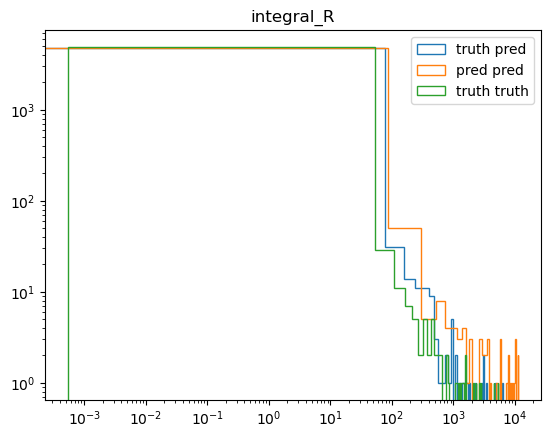

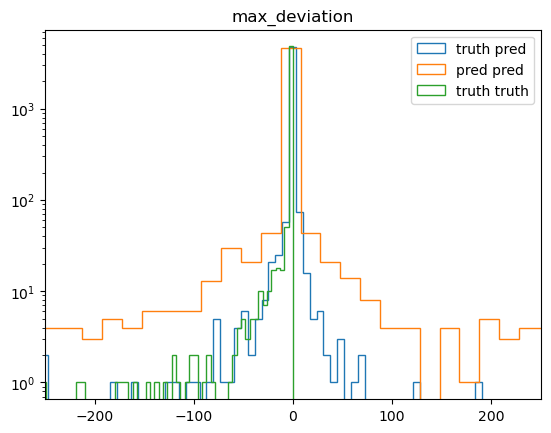

In [9]:
param = 'integral_R'
plt.figure()
plt.hist(test_df[f'{param}_truth_pred'], histtype='step', bins=100, label='truth pred')
plt.hist(test_df[f'{param}_pred_pred'], histtype='step', bins=100, label='pred pred')
plt.hist(test_df[f'{param}_truth_truth'], histtype='step', bins=100, label='truth truth')
plt.title(param)
# plt.xlim([-2000, 2000])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
#
param = 'max_deviation'
plt.figure()
plt.hist(test_df[f'{param}_truth_pred'], histtype='step', bins=100, label='truth pred')
plt.hist(test_df[f'{param}_pred_pred'], histtype='step', bins=100, label='pred pred')
plt.hist(test_df[f'{param}_truth_truth'], histtype='step', bins=100, label='truth truth')
plt.title(param)
plt.xlim([-250, 250])
# plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()